## Define The problem

In this notebook, we will train an MLP to classify images from the MNIST database hand-written digit database.
The process will be broken down into the following steps:



In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Visualize the Data
Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the batch_size if you want to load more data at a time.
This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses 
num_workers = 0
# how many  batch size to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.25

# convert data to FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split_num = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split_num:], indices[:split_num]

# define samplers for each training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
len(valid_loader)

750

## Visualize a Batch of Training Data
The first step in a classification task is to take a look at the data

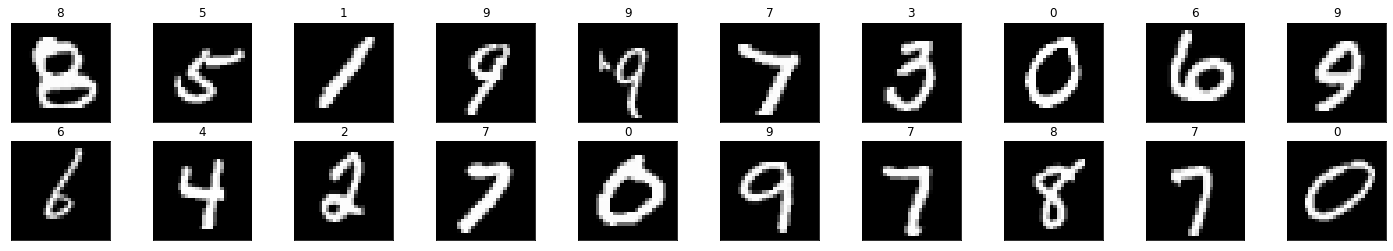

In [3]:

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## View an Image in More Detail

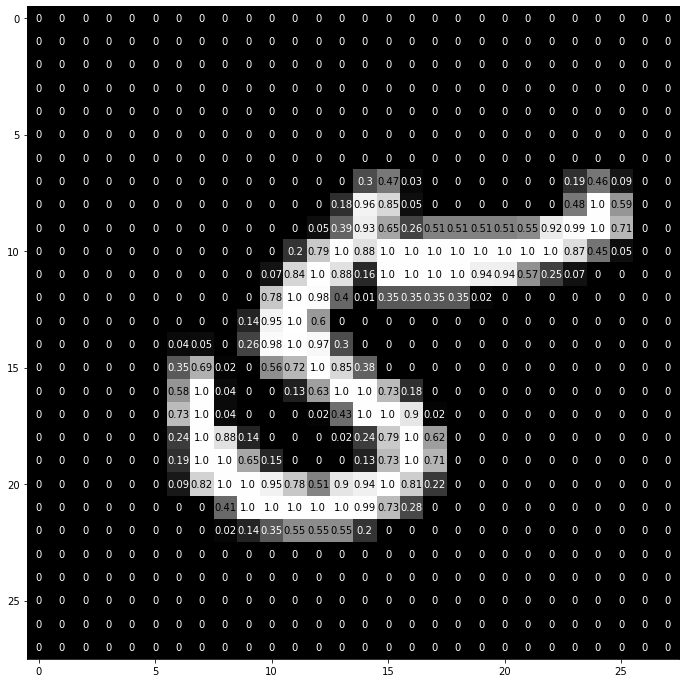

In [4]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture


In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the Neural Network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        drop_num=0.2
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(drop_num)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        x=F.log_softmax(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Specify Loss Function and Optimizer


In [6]:
# specify loss function 
criterion = nn.NLLLoss()
# specify optimizer (Adam optimizer) and learning rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

## Train the Network
The steps for training/learning from a batch of data are described in the comments below:

1- Clear the gradients of all optimized variables

2- Forward pass: compute predicted outputs by passing inputs to the model

3- Calculate the loss

4- Backward pass: compute gradient of the loss with respect to model parameters

5- Perform a single optimization step (parameter update)

6- Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [7]:

# number of epochs
n_epochs=35
train_losses=[]
valid_losses=[]
class_correct_valid = list(0. for i in range(10))
class_total_valid = list(0. for i in range(10))
class_correct_train = list(0. for i in range(10))
class_total_train = list(0. for i in range(10))

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    for epoch in range(n_epochs):
    # monitor training loss
    ###################
        train_loss=0

    # train the model #
    ###################
        model.train() # prep model for training
        for data, target_train in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target_train)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_train.data.view_as(pred)))
        # calculate training accuracy for each object class
        for i in range(len(target_train)):
            label = target_train.data[i]
            class_correct_train[label] += correct[i].item()
            class_total_train[label] += 1
            
    ######################    
    # validate the model #
    ######################
        model.eval() # prep model for evaluation
        valid_loss=0
        for data, target_valid in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target_valid)
            # update running validation loss 
            valid_loss += loss.item()

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)
        
        train_losses.append(train_loss)  
        valid_losses.append(valid_loss)
       
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_valid.data.view_as(pred)))
        # calculate validation accuracy for each object class
        for i in range(len(target_valid)):
            label = target_valid.data[i]
            class_correct_valid[label] += correct[i].item()
            class_total_valid[label] += 1
        

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
        print('\nTrain Accuracy (Overall): %4d%% (%4d/%4d)' % (
        100. * np.sum(class_correct_train) / np.sum(class_total_train),
        np.sum(class_correct_train), np.sum(class_total_train)))
        
        print('\nValidation Accuracy (Overall): %4d%% (%4d/%4d)' % (
        100. * np.sum(class_correct_valid) / np.sum(class_total_valid),
        np.sum(class_correct_valid), np.sum(class_total_valid)))
        
        
        

CUDA is available!  Training on GPU ...


C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.678223 	Validation Loss: 0.301904
Validation loss decreased (inf --> 0.301904).  Saving model ...

Train Accuracy (Overall):   95% (  19/  20)

Validation Accuracy (Overall):  100% (  20/  20)
Epoch: 2 	Training Loss: 0.275343 	Validation Loss: 0.212721
Validation loss decreased (0.301904 --> 0.212721).  Saving model ...

Train Accuracy (Overall):   92% (  37/  40)

Validation Accuracy (Overall):  100% (  40/  40)
Epoch: 3 	Training Loss: 0.199722 	Validation Loss: 0.165262
Validation loss decreased (0.212721 --> 0.165262).  Saving model ...

Train Accuracy (Overall):   93% (  56/  60)

Validation Accuracy (Overall):   96% (  58/  60)
Epoch: 4 	Training Loss: 0.157546 	Validation Loss: 0.144848
Validation loss decreased (0.165262 --> 0.144848).  Saving model ...

Train Accuracy (Overall):   92% (  74/  80)

Validation Accuracy (Overall):   96% (  77/  80)
Epoch: 5 	Training Loss: 0.130413 	Validation Loss: 0.119385
Validation loss decreased (0.144848 --> 0.11

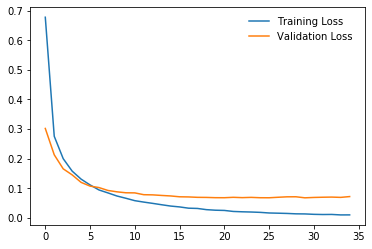

In [8]:
%matplotlib inline

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="Validation Loss ")
plt.legend(frameon=False)


## Load the Model with the Lowest Validation Loss

In [ ]:
best_model=model.load_state_dict(torch.load('model.pt'))

## Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [16]:
# initialize lists to monitor test loss and accuracy
test_loss =0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.068537

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 98% (1123/1135)
Test Accuracy of     2: 98% (1012/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 97% (867/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 98% (990/1009)

Test Accuracy (Overall): 97% (9798/10000)


In [21]:
test_losses

[0.06853679462598848]

## Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


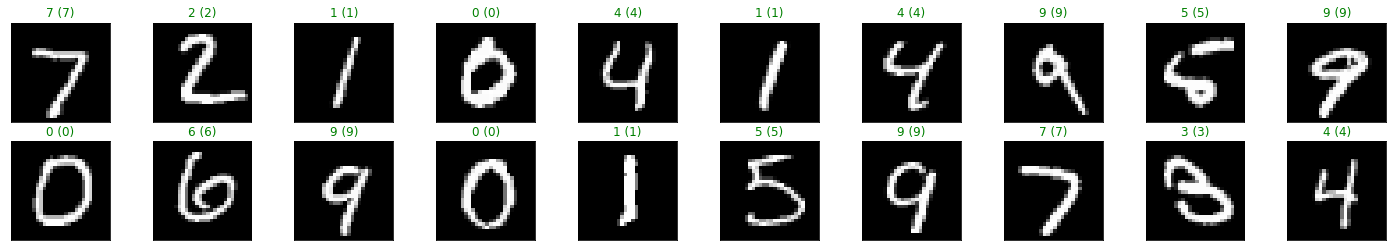

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))